In [292]:
import json
import os
import re
import shutil
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import cv2
from pycocotools import mask as maskUtils
import random
import pandas as pd
from PIL import Image
import uuid
import matplotlib.pyplot as plt
#from evaluation import test_class_performance

#Data Preprocessing
def convert_2_yolo(json_file, output_dir="./datasets/TACO/"):
    with open(json_file, 'r') as f:
        data = json.load(f)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for ann in data['annotations']:
        image_id = ann['image_id']
        image_info = data['images'][image_id]
        file_name = image_info['file_name']
        #formatted_filename = re.search(r"(\d+)\.jpg", file_name).group(1)
        #formatted_filename = os.path.splitext(filename_formatting(file_name))[0] + '.txt'
        normalized_path = os.path.normpath(file_name)
        formatted_filename = os.path.splitext(normalized_path)[0] + '.txt'
        img_width = image_info['width']
        img_height = image_info['height']
        yolo_annotations = []

        class_id = ann['category_id']
        segmentation = ann['segmentation'][0]
        bbox = ann['bbox']  # Assuming bbox format is [xmin, ymin, xmax, ymax]
        x1, y1, w, h = bbox
        
        # Normalize label values
        x_center = (x1 + w/2) / img_width
        y_center = (y1 + h/2) / img_height
        w = w / img_width
        h = h / img_height

        # Prepare the YOLO format line
        #yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

        normalized_coords = normalize_segments(segmentation, img_width, img_height)
        row = f"{class_id} " + " ".join([f"{coord:.6f}" for coord in normalized_coords]) + "\n"
        yolo_annotations.append(row)

        # Write annotations to a file in the YOLO format
        output_file = os.path.join(output_dir, formatted_filename)
        with open(output_file, 'a') as out_f:
            out_f.write(row)

        print(f"YOLO format annotations saved for image {image_id}")

def filename_formatting(filename):
    basename, image_name = filename.split("/")
    new_filename = str.lower(f"{basename}-{image_name}")

    return new_filename

def move_and_rename(filename, input_dir="./datasets/TACO/data", output_dir="./datasets/TACO/all_images/"):
    with open(filename, 'r') as f:
        data = json.load(f)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    for ann in data['annotations']:
        image_id = ann['image_id']
        image_info = data['images'][image_id]
        filename = image_info['file_name']

        new_filename = filename_formatting(filename)

        src = os.path.join(input_dir, filename)
        dest = os.path.join(output_dir, new_filename)

        if os.path.exists(output_dir):
            shutil.copy(src, dest)
            print(f"Image moved to: {output_dir}")
        else:
            print(f"Source image not found: {input_dir}")

def normalize_segments(coords, img_width, img_height):
    normalized = []
    for i in range(0, len(coords), 2):
        x = coords[i] / img_width
        y = coords[i + 1] / img_height
        normalized.append(x)
        normalized.append(y)
    return normalized

def normalize_bbox(coords, img_width, img_height):
    normalized = []
    for i in range(0, len(coords), 2):
        x = coords[i] / img_width
        y = coords[i + 1] / img_height
        normalized.append(x)
        normalized.append(y)
 
def data_splitting(filename="./datasets/TACO/annotations.json", all_labels="./datasets/TACO/tmp/labels", all_images="./datasets/TACO/tmp/images", train_dir="./datasets/TACO/train/", val_dir="./datasets/TACO/val/"):
    with open(filename, 'r') as f:
        data = json.load(f)

    filenames = []
    labels = []

    for ann in data['annotations']:
        image_id = ann['image_id']
        image_info = data['images'][image_id]
        filename = filename_formatting(image_info['file_name'])
        label = os.path.splitext(filename)[0] + '.txt'

        filenames.append(filename)
        labels.append(label)


    filename_ds = np.array(filenames)
    labels_ds = np.array(labels)

    X_train, X_val, y_train, y_val = train_test_split(filename_ds, labels_ds, test_size=0.2, shuffle=True)

    for i in X_train:
        shutil.copy(all_images+i, train_dir+"tmp/images/"+i)
    for i in y_train:
        shutil.copy(all_labels+i, train_dir+"labels/"+i)
    for i in X_val:
        shutil.copy(all_images+i, val_dir+"images/"+i)
    for i in y_val:
        shutil.copy(all_labels+i, val_dir+"labels/"+i)

def empty_directory(directory_path):
    # Check if the directory exists
    if os.path.exists(directory_path):
        # Iterate over all the files and directories within the given directory
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            
            # Check if it's a file or directory
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
                print(f"Deleted file: {file_path}")
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the directory
                print(f"Deleted directory: {file_path}")
    else:
        print(f"Directory {directory_path} does not exist!")

def convert_image_bw(input_dir, label_dir, output_dir=None):
    # Ensure the output directory exists
    if output_dir is None:
        output_dir = input_dir

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Loop through all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith((".jpg", ".png")):
            # Full path to the image
            img_path = os.path.join(input_dir, filename)
    
            # Load the image
            image = cv2.imread(img_path)
    
            if image is not None:  # Check if the image is loaded successfully
                # Convert the image to grayscale
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                new_filename = add_prefix("bw", filename)
    
                # Create the output file path
                output_path = os.path.join(output_dir, new_filename)
    
                # Save the grayscale image
                cv2.imwrite(output_path, gray_image)

                #old_label = os.path.splitext(filename)[0] + '.txt'
                #new_label = f"bw-{old_label}"

                # Add a new label file too
                #shutil.copy(label_dir+old_label, label_dir+new_label)
                print(f'Converted {filename} to grayscale.')
            else:
                print(f'Failed to load {filename}')
    
    copy_files_with_new_names(label_dir, prefix='bw_')
    print("All images have been processed.")

def copy_files_with_new_names(input_dir, output_dir=None, prefix='', suffix=''):
    # If no output directory is provided, use the input directory
    if output_dir is None:
        output_dir = input_dir

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all files in the input directory
    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)

        # Check if the current file is a regular file (not a directory)
        if os.path.isfile(file_path):
            # Split the filename and extension
            file_name, file_ext = os.path.splitext(filename)

            # Create the new filename with prefix or suffix
            new_filename = f"{prefix}{file_name}{suffix}{file_ext}"

            # Create the new file path
            new_file_path = os.path.join(output_dir, new_filename)

            # Copy the file to the new location with the new name
            shutil.copy(file_path, new_file_path)
            print(f"Copied {filename} to {new_filename}")

    print("All files have been copied and renamed.")

def flip_image(image, direction):
    """
    Augments the image by flipping it vertically and horizontally.

    Parameters:
    - image: The input image as a NumPy array.

    Returns:
    - original: The original image.
    - vertical_flip: The vertically flipped image.
    - horizontal_flip: The horizontally flipped image.
    - both_flips: The image flipped both vertically and horizontally.
    """
    
    # Ensure the input is a valid image
    if image is None:
        raise ValueError("Input image is None.")
    
    # Flip the image vertically
    flipped_image = cv2.flip(image, direction)  # 0 means flipping around the x-axis

    return flipped_image

def flip_augmentation(directory):
    """
    Applies augmentation to images with the 'original_' prefix in the specified directory.

    Parameters:
    - directory: Path to the directory containing images.
    """
    for filename in os.listdir(directory):
        if filename.startswith("original_") and filename.endswith((".jpg", ".png")):
            # Load the image
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            
            if image is not None:
                # Perform augmentation
                vertical_flip = flip_image(image, 0)
                horizontal_flip = flip_image(image, 1)
                
                # Save augmented images with modified names
                cv2.imwrite(os.path.join(directory, f"vertical_flip_{filename}"), vertical_flip)
                cv2.imwrite(os.path.join(directory, f"horizontal_flip_{filename}"), horizontal_flip)
                
                print(f'Augmented {filename} and saved flips.')
            else:
                print(f'Failed to load {filename}')

def add_prefix(prefix, filename):
    return f"{prefix}_{filename}"

#Augmentation functions
def add_noise(image, noise_ratio=0.001):
    noisy_image = image.copy()
    num_noisy_pixels = int(noise_ratio * image.shape[0] * image.shape[1])

    x_coords = np.random.randint(0, image.shape[1], num_noisy_pixels)
    y_coords = np.random.randint(0, image.shape[0], num_noisy_pixels)

    noisy_image[y_coords, x_coords] = np.random.randint(0, 256, (num_noisy_pixels, 3))

    return noisy_image

def apply_noise(image_dir, label_dir, strength):
    for filename in os.listdir(image_dir):
        if filename.startswith("original_"):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)

            noisy_image = add_noise(image, noise_ratio=strength)
            new_filename = add_prefix("noise", filename)
            new_filepath = os.path.join(image_dir, new_filename)
            cv2.imwrite(new_filepath, noisy_image)

            print("Creating noisy image")

    copy_files_with_new_names(label_dir, prefix='noise_')

def add_saturation(image, saturation_change=None):
    if saturation_change is None:
        saturation_change = np.random.uniform(-0.25, 0.25)

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv_image[:, :, 1] *= (1 + saturation_change)
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1], 0, 255)
    adjusted_image = cv2.cvtColor(hsv_image.astype(np.uint8), cv2.COLOR_HSV2BGR)

    return adjusted_image

def add_exposure(image, exposure_percent=0):
    exposure_percent = np.clip(exposure_percent, -10, 10)
    exposure_factor = 1 + (exposure_percent / 100.0)
    exposure_adjusted_image = cv2.convertScaleAbs(image, alpha=exposure_factor)

    return exposure_adjusted_image

def apply_exposure(image_dir, label_dir):
    for filename in os.listdir(image_dir):
        if filename.startswith("original_"):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)

            exposed_image = add_exposure(image)
            new_filename = add_prefix("exposed", filename)
            new_filepath = os.path.join(image_dir, new_filename)
            cv2.imwrite(new_filepath, exposed_image)

            print("Creating noisy image")

    copy_files_with_new_names(label_dir, prefix='exposed_')

def apply_saturation(image_dir, label_dir):
    for filename in os.listdir(image_dir):
        if filename.startswith("original_"):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)

            saturated_image = add_saturation(image)
            new_filename = add_prefix("saturated", filename)
            new_filepath = os.path.join(image_dir, new_filename)
            cv2.imwrite(new_filepath, saturated_image)

            print("Creating noisy image")

    copy_files_with_new_names(label_dir, prefix='saturated_')


def apply_seg_mask(image_dir, label_dir, output_dir=None, background_image_path=None):
    if output_dir is None:
        output_dir = image_dir

    for filename in os.listdir(image_dir):
        if filename.startswith("original_"):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            height, width = image.shape[:2]
            label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + '.txt')

            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    data = line.strip().split()
                    class_id = int(data[0])
                    polygon = np.array([[float(x) * width, float(y) * height] for x, y in zip(data[1::2], data[2::2])], dtype=np.int32)
                    cv2.fillPoly(mask, [polygon], color=(class_id + 1))

            masked_image = cv2.bitwise_and(image, image, mask=mask)

            if background_image_path:
                background = cv2.imread(background_image_path)
                background = cv2.resize(background, (image.shape[1], image.shape[0]))
            
            else: 
                background = np.zeros_like(image)
                background[:] = (0, 255, 0)

            inverted_mask = cv2.bitwise_not(mask)
            background_part = cv2.bitwise_and(background, background, mask=inverted_mask)
            final_image = cv2.add(masked_image, background_part)
            new_filename = add_prefix("no_background", filename)

            new_filepath = os.path.join(output_dir, new_filename)

            cv2.imwrite(new_filepath, final_image)

    copy_files_with_new_names(label_dir, prefix='no_background-')
   

def replace_classes_in_json(input_json_path, output_json_path, class_mapping):
    """
    Replaces class annotations in a COCO-style JSON file using a specified class mapping and writes the result to a new JSON file.

    Parameters:
    - input_json_path (str): Path to the input JSON file.
    - output_json_path (str): Path to the output JSON file where updated annotations will be saved.
    - class_mapping (dict): Dictionary mapping old class IDs to new class IDs.
    """
    # Load the original JSON data
    with open(input_json_path, 'r') as f:
        data = json.load(f)
    
    # Replace class IDs in each annotation
    for annotation in data.get('annotations', []):
        # Update 'category_id' if it exists in class_mapping
        if annotation['category_id'] in class_mapping:
            annotation['category_id'] = class_mapping[annotation['category_id']]
    
    # Write the updated data to a new JSON file
    with open(output_json_path, 'w') as f:
        json.dump(data, f, indent=4)
    
    print(f"Updated annotations saved to {output_json_path}")


def move_segmented_object(
    image_path, annotation_path, output_image_dir, output_annotation_dir, 
    background_dir=None, max_shift_ratio=0.2, apply_shift=True
):
    """
    Moves a segmented object to a random location in the image and replaces the background with a specified image.
    
    Parameters:
    - image_path: Path to the input image.
    - annotation_path: Path to the segmentation annotation file.
    - output_image_dir: Directory to save the modified image.
    - output_annotation_dir: Directory to save the updated annotation file.
    - background_dir: Directory containing background images. If None, uses a white background.
    - max_shift_ratio: Maximum shift as a fraction of the image dimensions.
    - apply_shift: If True, applies a random shift to the object; if False, keeps the object in place.
    
    Returns:
    - None
    """
    # Load the main image
    image = cv2.imread(image_path)
    
    # Check if image is loaded successfully
    if image is None:
        print(f"Error loading image: {image_path}")
        return

    height, width = image.shape[:2]

    # Select a random background image or use a white background if none is provided
    if background_dir and os.path.isdir(background_dir):
        background_filename = random.choice(os.listdir(background_dir))
        background = cv2.imread(os.path.join(background_dir, background_filename))
        
        # Check if background image loaded successfully
        if background is None:
            print(f"Error loading background image: {background_filename}")
            return
    else:
        background = np.ones_like(image) * 255  # White background

    # Resize background to match the original image dimensions
    background = cv2.resize(background, (width, height))

    # Parse the segmentation points from the annotation file
    try:
        with open(annotation_path, 'r') as file:
            lines = file.readlines()
    except Exception as e:
        print(f"Error reading annotation file: {annotation_path}. Error: {e}")
        return

    new_lines = []

    # Process each object in the annotation file
    for line in lines:
        data = line.strip().split()
        class_id = data[0]  # The class index
        
        try:
            points = np.array([[float(data[i]) * width, float(data[i + 1]) * height] for i in range(1, len(data), 2)], dtype=np.int32)
        except Exception as e:
            print(f"Error processing points in annotation line: {line}. Error: {e}")
            continue  # Skip to the next annotation line on error

        # Create mask for the object
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.fillPoly(mask, [points], color=255)

        # Calculate a random shift if apply_shift is True
        if apply_shift:
            max_dx = int(max_shift_ratio * width)
            max_dy = int(max_shift_ratio * height)
            dx = random.randint(-max_dx, max_dx)
            dy = random.randint(-max_dy, max_dy)
            translated_points = points + np.array([dx, dy])
        else:
            translated_points = points  # No shift applied

        # Ensure translated points are within image bounds
        translated_points = np.clip(translated_points, 0, [width - 1, height - 1])

        # Create a new mask for the moved object
        translated_mask = np.zeros_like(mask)
        cv2.fillPoly(translated_mask, [translated_points], color=255)

        # Place the moved object onto the background
        object_image = cv2.bitwise_and(image, image, mask=mask)

        # Ignore shape mismatch error
        try:
            background[translated_mask > 0] = object_image[mask > 0]  # Place original object on background
        except ValueError:
            print("Shape mismatch encountered while placing object on background. Skipping this object.")
            continue  # Skip to the next object on error

        # Update segmentation points by applying translation, and normalize
        new_points = [(x / width, y / height) for x, y in translated_points]
        new_line = f"{class_id} " + " ".join([f"{x:.6f} {y:.6f}" for x, y in new_points])
        new_lines.append(new_line)

    # Generate a unique name for the output files
    unique_id = uuid.uuid4().hex
    output_image_filename = f"aug_{unique_id}.jpg"
    output_annotation_filename = f"aug_{unique_id}.txt"

    # Prepare output paths for image and label
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_annotation_dir, exist_ok=True)
    output_image_path = os.path.join(output_image_dir, output_image_filename)
    output_annotation_path = os.path.join(output_annotation_dir, output_annotation_filename)

    # Save the modified image with the object moved
    cv2.imwrite(output_image_path, background)

    # Save the updated annotation
    with open(output_annotation_path, 'w') as file:
        file.write("\n".join(new_lines))

    print(f"Processed image saved to {output_image_path}")
    print(f"Updated annotation saved to {output_annotation_path}")


def rename_files_with_prefix(directory, prefix="original_"):
    """
    Renames every file in the specified directory by adding a prefix to the filename.

    Parameters:
    - directory: The directory containing files to rename.
    - prefix: The prefix to add to each filename (default is "original_").
    """
    # Ensure the directory exists
    if not os.path.isdir(directory):
        raise ValueError("Directory does not exist.")

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        # Create the full path for the current file
        old_path = os.path.join(directory, filename)

        # Skip directories
        if os.path.isfile(old_path):
            # Create the new filename with the prefix
            new_filename = prefix + filename
            new_path = os.path.join(directory, new_filename)

            # Rename the file
            os.rename(old_path, new_path)
            print(f'Renamed {filename} to {new_filename}')

import pickle

def find_images_without_labels(image_dir, label_dir, image_extensions=['.jpg', '.jpeg', '.png']):
    """
    Lists images in `image_dir` that have no corresponding label file in `label_dir`.

    Parameters:
    - image_dir (str): Path to the directory containing image files.
    - label_dir (str): Path to the directory containing label files.
    - image_extensions (list): List of image file extensions to consider (e.g., ['.jpg', '.png']).

    Returns:
    - List of image file names without corresponding label files.
    """
    # List all images in the image directory
    image_files = [f for f in os.listdir(image_dir) if os.path.splitext(f)[1].lower() in image_extensions]

    # List all label files in the label directory
    label_files = [os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.endswith('.txt')]

    # Find images without corresponding labels
    images_without_labels = [img for img in image_files if os.path.splitext(img)[0] not in label_files]

    return images_without_labels

def remove_images_without_labels(image_dir, label_dir, image_extensions=['.jpg', '.jpeg', '.png']):
    """
    Removes images in `image_dir` that have no corresponding label file in `label_dir`.

    Parameters:
    - image_dir (str): Path to the directory containing image files.
    - label_dir (str): Path to the directory containing label files.
    - image_extensions (list): List of image file extensions to consider (e.g., ['.jpg', '.png']).

    Returns:
    - List of deleted image file names.
    """
    # List all images in the image directory
    image_files = [f for f in os.listdir(image_dir) if os.path.splitext(f)[1].lower() in image_extensions]
    
    # List all label files in the label directory
    label_files = {os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.endswith('.txt')}
    
    # Find images without corresponding labels and remove them
    deleted_images = []
    for img in image_files:
        img_name = os.path.splitext(img)[0]
        if img_name not in label_files:
            img_path = os.path.join(image_dir, img)
            os.remove(img_path)
            deleted_images.append(img)
            print(f"Deleted: {img_path}")
    
    return deleted_images

def create_labels_from_csv(csv_file, images_dir, label_dir, class_mapping):
    """
    Creates label files in YOLO format from a CSV file, dynamically reading image dimensions.

    Parameters:
    - csv_file (str): Path to the CSV file containing bounding boxes and class names.
    - images_dir (str): Directory where the images are stored.
    - label_dir (str): Directory to save the generated label files.
    - class_mapping (dict): Mapping of class names to class indices (e.g., {'metal': 0, 'plastic': 1}).
    """
    # Ensure label directory exists
    os.makedirs(label_dir, exist_ok=True)

    # Load CSV file
    data = pd.read_csv(csv_file)

    # Process each row and create a label file
    for _, row in data.iterrows():
        image_name = row['image_name']
        x_min = row['x_min']
        y_min = row['y_min']
        x_max = row['x_max']
        y_max = row['y_max']
        class_name = row['class_name']

        # Construct the full image path
        image_path = os.path.join(images_dir, image_name)

        # Check if image exists
        if not os.path.exists(image_path):
            print(f"Warning: Image '{image_name}' not found. Skipping.")
            continue

        # Get image dimensions
        with Image.open(image_path) as img:
            img_width, img_height = img.size

        # Convert bounding box coordinates to YOLO format
        x_center = (x_min + x_max) / 2 / img_width
        y_center = (y_min + y_max) / 2 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        # Get class index from the class name
        class_index = class_mapping.get(class_name)
        if class_index is None:
            print(f"Warning: Class '{class_name}' not found in class mapping. Skipping.")
            continue

        # Create label file path
        formatted_filename = os.path.splitext(image_name)[0] + '.txt'
        label_file_path = os.path.join(label_dir, formatted_filename)

        # Write label in YOLO format
        with open(label_file_path, 'a') as f:
            f.write(f"{class_index} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        print(f"Label created for {image_name}")

def duplicate_images_with_class(image_dir, label_dir, output_dir, target_class):
    """
    Duplicates images and annotation files containing a specific object class.

    Parameters:
    - image_dir (str): Directory containing images.
    - label_dir (str): Directory containing annotation files with class information.
    - output_dir (str): Directory to save duplicated images and annotations.
    - target_class (int): Target object class to look for in annotation files.

    Returns:
    - None
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")
            
            # Check if annotation file exists
            if os.path.exists(label_path):
                with open(label_path, 'r') as label_file:
                    # Read each line in the annotation file
                    for line in label_file:
                        line_data = line.strip().split()
                        class_id = int(line_data[0])

                        # Duplicate image and label if target class is found
                        if class_id == target_class:
                            duplicate_image_path = os.path.join(image_dir, f"duplicate_{filename}")
                            duplicate_label_path = os.path.join(label_dir, f"duplicate_{os.path.splitext(filename)[0]}.txt")
                            shutil.copy(image_path, duplicate_image_path)
                            shutil.copy(label_path, duplicate_label_path)
                            print(f"Duplicated {filename} and its annotation containing class {target_class}")
                            break  # Move to the next image if class is found
            else:
                print(f"Annotation file not found for {filename}")


def generate_images(image_dir, label_dir, output_dir, target_class, count=1):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")
            
            # Check if annotation file exists
            if os.path.exists(label_path):
                with open(label_path, 'r') as label_file:
                    # Read each line in the annotation file
                    for line in label_file:
                        line_data = line.strip().split()
                        class_id = int(line_data[0])

                        # Duplicate image and label if target class is found
                        if class_id == target_class:
                            for i in range(count):
                                move_segmented_object(
                                    image_path=image_path,
                                    annotation_path=label_path,
                                    output_image_dir=output_dir,
                                    output_annotation_dir=label_dir,
                                    background_dir="./datasets/background_images",
                                    apply_shift=False
                                )
                            break  # Move to the next image if class is found
            else:
                print(f"Annotation file not found for {filename}")

def visualize_annotation_with_image(image_dir, label_dir, grid_size=(4, 6)):
    """
    Visualizes a grid of images with their segmentation annotations overlaid in blue.
    
    Parameters:
    - image_dir: Path to the directory containing the images.
    - label_dir: Path to the directory containing the segmentation annotation files.
    - grid_size: Tuple representing the grid size (rows, columns) to display the images.
    
    Returns:
    - None
    """
    image_filenames = [filename for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.png'))]
    
    # Set up the plot grid
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.flatten()

    for count, filename in enumerate(image_filenames[:rows*cols]):
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")
        
        # Load the original image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading image: {image_path}")
            continue
        
        # Convert the image from BGR to RGB for display in Matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get the dimensions of the image
        height, width = image.shape[:2]
        
        # Create a blank color mask in blue
        blue_mask = np.zeros((height, width, 3), dtype=np.uint8)
        blue_mask[:, :] = (0, 0, 255)  # OpenCV uses BGR, so (0, 0, 255) is blue
        
        # Parse the segmentation points from the annotation file
        with open(label_path, 'r') as file:
            lines = file.readlines()
        
        # Process each object in the annotation file
        for line in lines:
            data = line.strip().split()
            points = np.array([[float(data[i]) * width, float(data[i + 1]) * height] for i in range(1, len(data), 2)], dtype=np.int32)
        
            # Draw the polygon on the blue mask
            cv2.fillPoly(blue_mask, [points], color=(255, 0, 0))  # (255, 0, 0) is red in RGB, so specify blue
        
        # Combine the image with the blue mask using transparency
        combined_image = cv2.addWeighted(image, 0.7, blue_mask, 0.3, 0)

        # Plot the image with annotations on the grid
        ax = axes[count]
        ax.imshow(combined_image)
        ax.axis('off')
        ax.set_title(f"Image {count + 1}")
    
    plt.tight_layout()
    plt.show()

def load_annotations(label_path):
    """
    Loads annotations from a label file.

    Parameters:
    - label_path: Path to the label file.

    Returns:
    - A list of tuples where each tuple contains (image_file_name, class_id).
    """
    annotations = []
    try:
        with open(label_path, 'r') as file:
            for line in file.readlines():
                parts = line.strip().split()
                if len(parts) > 0:
                    class_id = int(parts[0])
                    image_file_name = os.path.basename(label_path).replace('.txt', '.jpg')  # Assuming .jpg extension
                    annotations.append((image_file_name, class_id))
    except Exception as e:
        print(f"Error reading label file {label_path}: {e}")
    
    return annotations

def remove_and_move_images_with_class(images_folder, target_folder, class_id_to_remove, label_folder):
    """
    Moves images that have a specific class ID to a target folder and removes their references from annotations.

    Parameters:
    - images_folder: Folder containing the images.
    - target_folder: Folder where the images with the specified class ID will be moved.
    - class_id_to_remove: The class ID to remove along with associated images.
    - label_folder: Folder containing the label files for the images.
    
    Returns:
    - None
    """
    # Create the target folder if it doesn't exist
    os.makedirs(target_folder, exist_ok=True)

    # Track images to keep
    images_to_keep = []

    # Loop through each label file in the label folder
    for label_file in os.listdir(label_folder):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_folder, label_file)
            annotations = load_annotations(label_path)

            for image_file_name, class_id in annotations:
                if class_id == class_id_to_remove:
                    # Move the image to the target folder
                    image_path = os.path.join(images_folder, image_file_name)
                    target_path = os.path.join(target_folder, image_file_name)
                    if os.path.exists(image_path):
                        shutil.move(image_path, target_path)
                        print(f"Moved image {image_file_name} to {target_folder}")
                    else:
                        print(f"Image {image_file_name} not found in {images_folder}")
                else:
                    images_to_keep.append(image_file_name)

    # Optionally return the list of images that were kept or any other relevant information
    return images_to_keep


if __name__== "__main__":
    batch_annotations = "./datasets/TACO/batch_1/annotations.json"
    all_annotations = "./datasets/TACO/data/annotations.json"
    all_labels = "./datasets/TACO/all_labels"
    all_images = "./datasets/TACO/all_images"
    
    #trashnet - training
    trashnet_img_output = "./datasets/trashnet/train/labels"
    trashnet_annotations = "./datasets/trashnet/train/_annotations.coco.json"

    #trashnet - validation
    trashnet_val_output = "./datasets/trashnet/valid/labels"
    trashnet_val_annotations = "./datasets/trashnet/valid/_annotations.coco.json"

    taco_aug_label_train = "./datasets/taconet/train/labels" 
    taco_aug_label_val = "./datasets/taconet/val/labels" 

    #empty_directory("./datasets/TACO/val/images")
    #empty_directory("./datasets/TACO/val/labels")
    #empty_directory("./datasets/TACO/train/images")
    #empty_directory("./datasets/TACO/train/labels")

    # convert_2_yolo("./datasets/splits_final_deblurred/val/labels.json", output_dir="./datasets/splits_final_deblurred/val/labels")
    # convert_2_yolo("./datasets/splits_final_deblurred/train/labels.json", output_dir="./datasets/splits_final_deblurred/train/labels")
    # convert_2_yolo("./datasets/cig_butts/train/new_ann.json", output_dir="./datasets/cig_butts/train/labels")
    
    # convert_2_yolo("./datasets/glassbottles/train/_annotations.coco.json", output_dir="./datasets/glassbottles/train/labels")
    # convert_2_yolo("./datasets/glassbottles/valid/_annotations.coco.json", output_dir="./datasets/glassbottles/valid/labels")
    #move_and_rename(all_annotations)
    #data_splitting()
    #convert_image_bw("./datasets/taconet/train/images", taco_aug_label_train)
    #convert_image_bw("./datasets/taconet/val/images", taco_aug_label_val)

    # copy_files_with_new_names("./datasets/trashnet/tmp/images", output_dir="./datasets/taconet/tmp/images", prefix='trashnet-')
    # copy_files_with_new_names("./datasets/trashnet/tmp/labels", output_dir="./datasets/taconet/tmp/labels", prefix='trashnet-')
    # copy_files_with_new_names("./datasets/TACO/tmp/images", output_dir="./datasets/taconet/tmp/images", prefix='taco-')
    # copy_files_with_new_names("./datasets/TACO/tmp/labels", output_dir="./datasets/taconet/tmp/labels", prefix='taco-')

    #apply_seg_mask("./datasets/waste/train/images", label_dir="./datasets/waste/train/labels")
    #apply_seg_mask("./datasets/waste/val/images", label_dir="./datasets/waste/val/labels")
    #rename_files_with_prefix("./datasets/waste/train/labels")
    #rename_files_with_prefix("./datasets/waste/train/images")
    #flip_augmentation("./datasets/TACO_aug/train/images")
    #copy_files_with_new_names("./datasets/TACO_aug/train/labels", prefix='-')

    #rename_files_with_prefix("./datasets/waste/val/images")
    #rename_files_with_prefix("./datasets/waste/val/labels")
    #flip_augmentation("./datasets/TACO_aug/val/images")
    #rename_files_with_prefix("./datasets/taco4/train/images", prefix='taco-')
    #rename_files_with_prefix("./datasets/taco4/train/labels", prefix='taco-')
    # rename_files_with_prefix("./datasets/cig_butts/train/images", prefix='cigbutts-')
    # rename_files_with_prefix("./datasets/cig_butts/train/labels", prefix='cigbutts-')
    # rename_files_with_prefix("./datasets/cig_butts/val/images", prefix='cigbutts-')
    # rename_files_with_prefix("./datasets/autolabel_images/alu_results/train/images/", prefix='drinkingdata-')
    # rename_files_with_prefix("./datasets/autolabel_images/alu_results/train/labels/", prefix='drinkingdata-')
    # rename_files_with_prefix("./datasets/autolabel_images/alu_results/valid/images/", prefix='drinkingdata-')
    # rename_files_with_prefix("./datasets/autolabel_images/alu_results/valid/labels/", prefix='drinkingdata-')
    # rename_files_with_prefix("./datasets/autolabel_images/glass_results/train/images/", prefix='drinkingdata-')
    # rename_files_with_prefix("./datasets/autolabel_images/glass_results/train/labels/", prefix='drinkingdata-')
    # rename_files_with_prefix("./datasets/autolabel_images/glass_results/valid/images/", prefix='drinkingdata-')
    # rename_files_with_prefix("./datasets/autolabel_images/glass_results/valid/labels/", prefix='drinkingdata-')

    #apply_noise("./datasets/TACO_aug/train/images", taco_aug_label_train, 0.3)
    #apply_noise("./datasets/TACO_aug/val/images", taco_aug_label_val, 0.3)

    #apply_exposure("./datasets/TACO_aug/train/images", taco_aug_label_train)
    #apply_exposure("./datasets/TACO_aug/val/images", taco_aug_label_val)
    #apply_saturation("./datasets/TACO_aug/train/images", taco_aug_label_train)

    #import splitfolders
    #splitfolders.ratio('./datasets/TACO/tmp/', output="./datasets/taco2", seed=4321, ratio=(.8, .2))
    
    class_mapping = {
        0: 1,  # Aluminium foil -> Metals
        2: 1,  # Aluminium blister pack -> Metals
        8: 1,  # Metal bottle cap -> Metals
        10: 1, # Food Can -> Metals
        11: 1, # Aerosol -> Metals
        12: 1, # Drink can -> Metals
        28: 1, # Metal lid -> Metals
        50: 1, # Pop tab -> Metals
        52: 1, # Scrap metal -> Metals
        4: 4,   # Other plastic bottle -> Plastic
        5: 4,   # Clear plastic bottle -> Plastic
        7: 4,   # Plastic bottle cap -> Plastic
        21: 4,  # Disposable plastic cup -> Plastic
        22: 4,  # Foam cup -> Plastic
        24: 4,  # Other plastic cup -> Plastic
        27: 4,  # Plastic lid -> Plastic
        29: 4,  # Other plastic -> Plastic
        35: 4,  # Plastified paper bag -> Plastic
        36: 4,  # Plastic film -> Plastic
        37: 4,  # Six pack rings -> Plastic
        38: 4,  # Garbage bag -> Plastic
        39: 4,  # Other plastic wrapper -> Plastic
        40: 4,  # Single-use carrier bag -> Plastic
        41: 4,  # Polypropylene bag -> Plastic
        42: 4,  # Crisp packet -> Plastic
        43: 4,  # Spread tub -> Plastic
        44: 4,  # Tupperware -> Plastic
        45: 4,  # Disposable food container -> Plastic
        46: 4,  # Foam food container -> Plastic
        47: 4,  # Other plastic container -> Plastic
        48: 4,  # Plastic gloves -> Plastic
        49: 4,  # Plastic utensils -> Plastic
        54: 4,  # Squeezable tube -> Plastic
        55: 4,  # Plastic straw -> Plastic
        57: 4,  # Styrofoam piece -> Plastic
        3: 2,   # Carded blister pack -> Cardboard
        13: 2,  # Toilet tube -> Cardboard
        14: 2,  # Other carton -> Cardboard
        15: 2,  # Egg carton -> Cardboard
        16: 2,  # Drink carton -> Cardboard
        17: 2,  # Corrugated carton -> Cardboard
        18: 2,  # Meal carton -> Cardboard
        19: 2,  # Pizza box -> Cardboard
        20: 2,  # Paper cup -> Cardboard
        30: 2,  # Magazine paper -> Cardboard
        31: 2,  # Tissues -> Cardboard
        32: 2,  # Wrapping paper -> Cardboard
        33: 2,  # Normal paper -> Cardboard
        34: 2,  # Paper bag -> Cardboard
        56: 2,
        6: 6,  # Glass bottle -> Glass
        9: 6,  # Broken glass -> Glass
        23: 6, # Glass cup -> Glass
        26: 6,
        51: 3,  # Rope & strings -> Textile
        53: 3,
        1: 0,
        25: 7,
        58: 8,
        59: 5
    }

    class_mapping2 = {
        0:8,
        5:4,
        3:2,
    }

    class_mapping3 = {
        'glass': 0,
        'paper': 1,
        'metal': 2,
        'plastic': 3
    }
    class_mapping4 = {
        0:0,
        3:0,
        1:2,
        2:1,
    }

    class_mapping5 = {
        0:1,
        2:1,
        3:6
    }
    
    #create_labels_from_csv("./datasets/AquaTrash/annotations.csv", "./datasets/AquaTrash/tmp/images", "./datasets/AquaTrash/tmp/labels", class_mapping3)
    # Call the function
    #replace_classes_in_json("./datasets/splits_final_deblurred/train/labels.json", "./datasets/splits_final_deblurred/train/new_ann.json", class_mapping4)
    #replace_classes_in_json("./datasets/splits_final_deblurred/val/labels.json", "./datasets/splits_final_deblurred/val/new_ann.json", class_mapping4)
    #replace_classes_in_json("./datasets/trashnet/train/_annotations.coco.json", "./datasets/trashnet/train/new_ann.json", class_mapping2)
    # replace_classes_in_json("./datasets/cig_butts/train/coco_annotations.json", "./datasets/cig_butts/train/new_ann.json", class_mapping5)
    # replace_classes_in_json("./datasets/autolabel_images/images/_annotations.coco.json", "./datasets/drinkingdata/new_ann.json", class_mapping5)
    #duplicate_images_with_class("./datasets/taconet/train/images", "./datasets/taconet/train/labels", "./datasets/taconet/tmp/dups", 6)
    #remove_images_without_labels("datasets/trashnet/valid/images", "datasets/trashnet/valid/labels")
    images = find_images_without_labels("datasets/taconet/val/images", "datasets/taconet/val/labels")
    #images = find_images_without_labels("datasets/drinkingdata/images", "datasets/drinkingdata/labels")

    # Example usage
    
    # move_segmented_object(
    #     image_path="./datasets/taconet/train/images/trashnet-plastic_container_150_jpg.rf.3aa64d81def90353a35d7713c9e81ae3.jpg",
    #     annotation_path="./datasets/taconet/train/labels/trashnet-plastic_container_150_jpg.rf.3aa64d81def90353a35d7713c9e81ae3.txt",
    #     output_image_dir="./datasets/taconet",
    #     output_annotation_dir="./datasets/taconet",
    #     background_dir="./datasets/background_images"
    # )

    # generate_images("./datasets/taconet/train/images", "./datasets/taconet/train/labels", "./datasets/taconet/train/images", 1, count=1)
    # generate_images("./datasets/taconet/train/images", "./datasets/taconet/train/labels", "./datasets/taconet/train/images", 2, count=2)
    #generate_images("./datasets/taconet/train/images", "./datasets/taconet/train/labels", "./datasets/taconet/train/images", 6, count=2)
    # generate_images("./datasets/glassbottles/train/images", "./datasets/glassbottles/train/labels", "./datasets/glassbottles/train/images", 1, count=20)
    # generate_images("./datasets/glassbottles/valid/images", "./datasets/glassbottles/valid/labels", "./datasets/glassbottles/valid/images", 1, count=5)
    # generate_images("./datasets/drinkingdata/images", "./datasets/drinkingdata/labels", "./datasets/drinkingdata/images", 6, count=8)
    # generate_images("./datasets/drinkingdata/images", "./datasets/drinkingdata/labels", "./datasets/drinkingdata/images", 1, count=2)

    # generate_images("./datasets/taco2/val/images", "./datasets/taco2/val/labels", "./datasets/taco2/val/images", 1, count=1)
    # generate_images("./datasets/taco2/val/images", "./datasets/taco2/val/labels", "./datasets/taco2/val/images", 2, count=1)

    # visualize_annotation_with_image("./datasets/autolabel_images/alu_results/train/images", "./datasets/autolabel_images/alu_results/train/labels")
    for i in images:
        print(i)
    print(len(images))








0


In [256]:
def update_class_id_in_labels(label_dir, old_class_id, new_class_id):
    """
    Updates the class ID in all label.txt files in a directory.

    Parameters:
    - label_dir: Path to the directory containing label.txt files.
    - old_class_id: The class ID to replace.
    - new_class_id: The new class ID to set.
    
    Returns:
    - None
    """
    # Iterate over all files in the label directory
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            file_path = os.path.join(label_dir, label_file)
            
            # Read lines from the file
            with open(file_path, "r") as file:
                lines = file.readlines()
            
            # Update class IDs in each line
            new_lines = []
            for line in lines:
                parts = line.strip().split()
                
                # Check if the first part is the old class ID and replace it
                if parts[0] == str(old_class_id):
                    parts[0] = str(new_class_id)
                
                # Reconstruct the line and add it to the list of new lines
                new_lines.append(" ".join(parts))
            
            # Write the updated lines back to the file
            with open(file_path, "w") as file:
                file.write("\n".join(new_lines))
    
    print(f"Class ID {old_class_id} updated to {new_class_id} in all label files in {label_dir}.")

update_class_id_in_labels("/home/users/lweber/trash_detector/datasets/autolabel_images/glass_results/train/labels", 0, 6)

Class ID 0 updated to 6 in all label files in /home/users/lweber/trash_detector/datasets/autolabel_images/glass_results/train/labels.


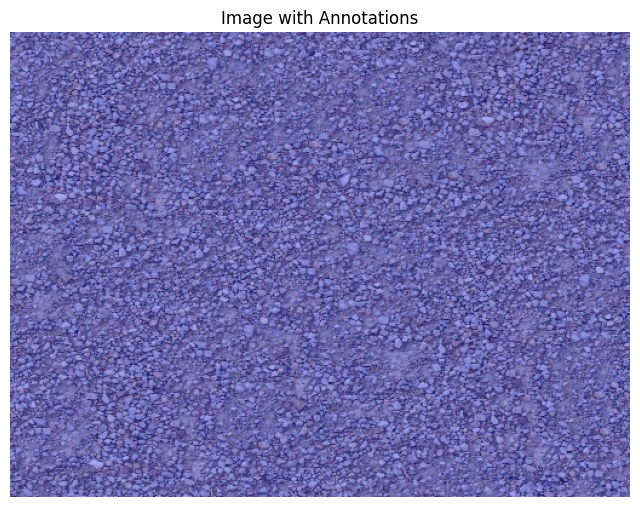

In [294]:
def visualize_annotation_with_image_by_path(image_path, label_dir):
    """
    Visualizes a single image with its segmentation annotations overlaid in red.
    
    Parameters:
    - image_path: Path to the image file.
    - label_dir: Path to the directory containing the segmentation annotation files.
    
    Returns:
    - None
    """
    # Extract the image filename and corresponding label file
    filename = os.path.basename(image_path)
    label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

    # Load the original image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return
    
    # Convert the image from BGR to RGB for display in Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Create a blank color mask in blue
    blue_mask = np.zeros((height, width, 3), dtype=np.uint8)
    blue_mask[:, :] = (0, 0, 255)  # OpenCV uses BGR, so (0, 0, 255) is blue

    # Parse the segmentation points from the annotation file
    try:
        with open(label_path, 'r') as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"Annotation file not found: {label_path}")
        return

    # Process each object in the annotation file
    for line in lines:
        data = line.strip().split()
        points = np.array([[float(data[i]) * width, float(data[i + 1]) * height] for i in range(1, len(data), 2)], dtype=np.int32)

        # Draw the polygon on the blue mask
        cv2.fillPoly(blue_mask, [points], color=(255, 0, 0))  # Red color for GT mask in RGB

    # Combine the image with the blue mask using transparency
    combined_image = cv2.addWeighted(image_rgb, 0.7, blue_mask, 0.3, 0)

    # Plot the image with annotations
    plt.figure(figsize=(8, 8))
    plt.imshow(combined_image)
    plt.axis('off')  # Hide axes
    plt.title(f"Image with Annotations")
    plt.show()

visualize_annotation_with_image_by_path("/home/users/lweber/trash_detector/datasets/taconet/train/images/aug_0dbc6df6ae9e4f9cb80ce5b9cdb29235.jpg", "/home/users/lweber/trash_detector/datasets/taconet/train/labels")

    

In [ ]:
import os

import glob
import pandas as pd

def get_images_with_class(root_directory, target_class_id=6):
    """
    Scans the labels directory for YOLO annotations with the specified class ID and
    returns the file paths of corresponding images with any extension.

    Parameters:
    - root_directory: Path to the directory containing the "images" and "labels" subdirectories.
    - target_class_id: The class ID to search for in annotations (default is 7).

    Returns:
    - List of file paths to images with annotations of the specified class ID.
    """
    image_paths_with_class = []
    
    # Define paths for the images and labels subdirectories
    images_dir = os.path.join(root_directory, "images")
    labels_dir = os.path.join(root_directory, "labels")

    # Supported image extensions
    image_extensions = ['.jpg', '.jpeg', '.png']

    # Iterate through each label file in the labels directory
    for label_filename in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_filename)
        
        # Read the label file line by line
        with open(label_path, 'r') as label_file:
            for line in label_file:
                # Split line by whitespace to get the class ID (first element)
                data = line.strip().split()
                class_id = int(data[0])
                
                # Check if the class ID matches the target
                if class_id == target_class_id:
                    # Find the corresponding image file in images directory with any extension
                    base_filename = os.path.splitext(label_filename)[0]
                    for ext in image_extensions:
                        image_path = os.path.join(images_dir, base_filename + ext)
                        if os.path.exists(image_path):
                            image_paths_with_class.append(image_path)
                            break  # Found the image, stop checking other extensions
                    break  # Stop checking other lines in the file as we found the target class
    
    return image_paths_with_class


# Example usage
root_dir = "/home/users/lweber/trash_detector/datasets/taconet/train"
images_with_class_6 = get_images_with_class(root_dir)
print("Images containing class :", len(images_with_class_6))


Images containing class : 159


In [234]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from ultralytics import YOLO
from ultralytics.engine.results import Boxes, Masks  # Adjust imports as needed

def visualize_and_save_detection(image_path,result,savedir):
    """
    Visualizes bounding boxes, masks, and class names from a YOLO result object on the image,
    then saves the annotated image.
    
    Parameters:
    - result: YOLO result object containing boxes, masks, and class names.

    Returns:
    - None
    """
    # Load the original image
    image = result.orig_img.copy()
    data = []
    # Overlay bounding boxes
    if isinstance(result.boxes, Boxes):
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box[:4])  # Extract coordinates
            class_id = int(box[-1])  # Assuming last item in box is class ID
            classid = result.boxes.cls
            label = result.names[classid.cpu().numpy()[0]]
            
            # Draw bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
            
            # Add class label text
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, (0, 255, 0), 6)
            
            data.append({
                "image_path": image_path,
                "label": label,
                "bbox": (x1, y1, x2, y2),
                "mask": None  # Default to None; will add if mask exists
            })
            
        
    
    # Overlay masks
    
    if isinstance(result.masks, Masks):
        for mask, class_id, detection_data in zip(result.masks.data, result.boxes.cls, data):
            # Convert mask to NumPy array if it's a PyTorch tensor
            if isinstance(mask, torch.Tensor):
                mask = mask.cpu().numpy()
            
            # Normalize and threshold the mask to create a binary image
            binary_mask = (mask * 255).astype(np.uint8)
            _, binary_mask = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)
            
            # Find contours for the binary mask
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                cv2.drawContours(image, [contour], -1, color=(255, 0, 0), thickness=2)

            # Update detection data with mask and add mask to detection info
            detection_data["mask"] = result.masks.segments

    # # Save the annotated image
    # save_path = os.path.join(savedir, f"annotated_{os.path.basename(image_path)}")
    # cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
    
    return data
    


In [238]:
import os
import random
import cv2
from ultralytics import YOLO  # Use YOLO v8 from the Ultralytics library, or adapt if using a different version.
import pandas as pd
import torch

def detect_and_save_random_sample(model_path, image_paths, sample_size, save_dir):
    """
    Runs YOLO predictions on a random sample of images and saves the results.

    Parameters:
    - model_path: Path to the trained YOLO model.
    - image_paths: List of file paths to images.
    - sample_size: Number of images to randomly sample for prediction.
    - save_dir: Directory to save the detection images.

    Returns:
    - None
    """
    # Load the YOLO model
    model = YOLO(model_path)

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Select a random sample of images from the provided list
    sample_paths = random.sample(image_paths, min(sample_size, len(image_paths)))

    data_list = []

    # Process each image in the random sample
    for image_path in sample_paths:
        # Run the prediction
        results = model.predict(source=image_path)
        print(results[0].masks)
        
        # Get detections and add to data_list
        data = visualize_and_save_detection(image_path, results[0], save_dir)
        
        # Ensure data is in DataFrame format and extend data_list with DataFrame rows
        if isinstance(data, list):  # If data is a list, convert it to a DataFrame
            data_df = pd.DataFrame(data)
        else:
            data_df = data
            
        data_list.append(data_df)

    # Combine all rows into a single DataFrame and return it
    final_df = pd.concat(data_list, ignore_index=True)
    return final_df
        

# Example usages
model_path = "/home/users/lweber/trash_detector/runs/segment/train37/weights/best.pt"  # Path to your trained YOLO model  # Replace with your list of images
sample_size = 50 # Number of random images to select
save_dir = "/home/users/lweber/trash_detector/runs/testdetect" # Directory to save detection images

pred_df = detect_and_save_random_sample(model_path, images_with_class_6, sample_size, save_dir)
print(pred_df['mask'].head())
# print(len(pred_df))



image 1/1 /home/users/lweber/trash_detector/datasets/taconet/train/images/Glass323_jpg.rf.fbba5fec2acecdbdc70bcd83e4db944f.jpg: 640x640 (no detections), 337.2ms
Speed: 1.5ms preprocess, 337.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
None

image 1/1 /home/users/lweber/trash_detector/datasets/taconet/train/images/Glass227_jpg.rf.d25c1f873d2211e7292cd11240ed6a29.jpg: 640x640 (no detections), 333.2ms
Speed: 1.7ms preprocess, 333.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
None

image 1/1 /home/users/lweber/trash_detector/datasets/taconet/train/images/Glass242_jpg.rf.98c373fd415303210700fdad91153f01.jpg: 640x640 (no detections), 334.8ms
Speed: 1.6ms preprocess, 334.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
None

image 1/1 /home/users/lweber/trash_detector/datasets/taconet/train/images/taco-batch_7-000075.jpg: 480x640 1 plastic, 260.2ms
Speed: 3.4ms preprocess, 260.2ms inference, 1.8ms postprocess per image at sha

AttributeError: 'Masks' object has no attribute 'segments'. See valid attributes below.

    A class for storing and manipulating detection masks.

    This class extends BaseTensor and provides functionality for handling segmentation masks,
    including methods for converting between pixel and normalized coordinates.

    Attributes:
        data (torch.Tensor | numpy.ndarray): The raw tensor or array containing mask data.
        orig_shape (tuple): Original image shape in (height, width) format.
        xy (List[numpy.ndarray]): A list of segments in pixel coordinates.
        xyn (List[numpy.ndarray]): A list of normalized segments.

    Methods:
        cpu(): Returns a copy of the Masks object with the mask tensor on CPU memory.
        numpy(): Returns a copy of the Masks object with the mask tensor as a numpy array.
        cuda(): Returns a copy of the Masks object with the mask tensor on GPU memory.
        to(*args, **kwargs): Returns a copy of the Masks object with the mask tensor on specified device and dtype.

    Examples:
        >>> masks_data = torch.rand(1, 160, 160)
        >>> orig_shape = (720, 1280)
        >>> masks = Masks(masks_data, orig_shape)
        >>> pixel_coords = masks.xy
        >>> normalized_coords = masks.xyn
    

In [312]:
def create_df(labels_dir, images_dir):
    """
    Creates a DataFrame of image paths, labels, masks, and bounding boxes from YOLO annotation files.

    Parameters:
    - labels_dir: Directory containing label files in YOLO format.
    - images_dir: Directory containing the corresponding images.

    Returns:
    - DataFrame with columns: 'image_path', 'label_path', 'label', 'mask', 'bbox'
    """
    data = []

    # Traverse through the labels directory and process each file
    for root, _, files in os.walk(labels_dir):
        for label_file in files:
            if label_file.endswith('.txt'):
                label_path = os.path.join(root, label_file)
                image_filename = os.path.splitext(label_file)[0] + ".jpg"  # Assuming .jpg images
                image_path = os.path.join(images_dir, image_filename)

                # Read each line of the label file
                with open(label_path, 'r') as file:
                    for line in file:
                        parts = line.strip().split()
                        class_id = int(parts[0])

                        # Extract bounding box
                        x_center, y_center, width, height = map(float, parts[1:5])
                        # Convert from normalized to pixel coordinates
                        image_width, image_height = 1920, 1080  # Set image dimensions as needed
                        xmin = int((x_center - width / 2) * image_width)
                        ymin = int((y_center - height / 2) * image_height)
                        xmax = int((x_center + width / 2) * image_width)
                        ymax = int((y_center + height / 2) * image_height)

                        bbox = (xmin, ymin, xmax, ymax)  # Bounding box in pixel coordinates

                        # Assuming mask data is included in the file (adjust as necessary)
                        mask_data = parts[5:]  # Assuming remaining parts are mask data
                        mask_array = np.array(mask_data, dtype=float).reshape(-1, 2)  # Example shape adjustment

                        # Append the collected data to the list
                        data.append({
                            "image_path": image_path,
                            "label_path": label_path,
                            "label": class_id,  # Store the class id from YOLO
                            "mask": mask_array,
                            "bbox": bbox  # Add bbox to the DataFrame
                        })
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["image_path", "label_path", "label", "mask", "bbox"])
    return df

# Example usage
labels_dir = "/home/users/lweber/trash_detector/datasets/taconet/train/labels"
images_dir = "/home/users/lweber/trash_detector/datasets/taconet/train/images"  # Replace with your images directory path
main_df = create_df(labels_dir, images_dir)


val_labels_dir = "/home/users/lweber/trash_detector/datasets/taconet/val/labels"
val_images_dir = "/home/users/lweber/trash_detector/datasets/taconet/val/images"  # Replace with your images directory path
val_main_df = create_df(val_labels_dir, val_images_dir)


In [247]:
def create_binary_mask(mask_points, image_width, image_height):
    """
    Converts a list of polygon points (normalized coordinates) to a binary mask.
    
    Parameters:
    - mask_points: List of polygon points [[x1, y1], [x2, y2], ..., [xn, yn]]
    - image_width: Width of the image
    - image_height: Height of the image
    
    Returns:
    - Binary mask (numpy array) of shape (image_height, image_width)
    """
    # Convert normalized coordinates to pixel coordinates
    pixel_points = np.array([[int(x * image_width), int(y * image_height)] for x, y in mask_points], dtype=np.int32)
    
    # Check if we have at least three points to form a polygon
    if len(pixel_points) >= 3:
        # Ensure the polygon is closed by appending the first point to the end, if necessary
        if not np.array_equal(pixel_points[0], pixel_points[-1]):
            pixel_points = np.vstack([pixel_points, pixel_points[0]])
    
    # Create an empty mask (all zeros)
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    
    # Fill the polygon (defined by mask_points) in the mask with 1
    cv2.fillPoly(mask, [pixel_points], color=1)
    
    return mask

def create_ground_truth_df(labels_dir, images_dir, target_class):
    """
    Creates a DataFrame of image paths, labels, binary masks, and bounding boxes for a specified class from YOLO annotation files.

    Parameters:
    - labels_dir: Directory containing label files in YOLO format.
    - images_dir: Directory containing the corresponding images.
    - target_class: The class label to filter and collect data for.

    Returns:
    - DataFrame with columns: 'image_path', 'label', 'mask', 'bbox'
    """
    data = []

    # Traverse through the labels directory and process each file
    for root, _, files in os.walk(labels_dir):
        for label_file in files:
            if label_file.endswith('.txt'):
                label_path = os.path.join(root, label_file)
                image_filename = os.path.splitext(label_file)[0] + ".jpg"  # Assuming .jpg images
                image_path = os.path.join(images_dir, image_filename)

                # Read each line of the label file
                with open(label_path, 'r') as file:
                    for line in file:
                        parts = line.strip().split()
                        class_id = int(parts[0])

                        # Filter for the target class
                        if class_id == target_class:
                            # Extract bounding box
                            x_center, y_center, width, height = map(float, parts[1:5])
                            # Convert from normalized to pixel coordinates
                            image_width, image_height = 1920, 1080  # Set image dimensions as needed
                            xmin = int((x_center - width / 2) * image_width)
                            ymin = int((y_center - height / 2) * image_height)
                            xmax = int((x_center + width / 2) * image_width)
                            ymax = int((y_center + height / 2) * image_height)

                            bbox = (xmin, ymin, xmax, ymax)  # Bounding box in pixel coordinates

                            # Assuming mask data is included in the file (adjust as necessary)
                            mask_data = parts[5:]  # Assuming remaining parts are mask data
                            mask_array = np.array(mask_data, dtype=float).reshape(-1, 2)  # Example shape adjustment

                            # Convert polygon mask to binary mask
                            binary_mask = create_binary_mask(mask_array, image_width, image_height)

                            # Append the collected data to the list
                            data.append({
                                "image_path": image_path,
                                "label_path": label_path,
                                "label": "glass",  # Assuming a fixed class name; adjust as needed
                                "mask": binary_mask,
                                "bbox": bbox  # Add bbox to the DataFrame
                            })
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["image_path", "label_path", "label", "mask", "bbox"])
    return df

# Example usage
labels_dir = "/home/users/lweber/trash_detector/datasets/taconet/train/labels"
images_dir = "/home/users/lweber/trash_detector/datasets/taconet/train/images"
target_class = 6  # Replace with desired class ID
df = create_ground_truth_df(labels_dir, images_dir, target_class)
# pd.set_option('display.max_colwidth', None)
print(df['mask'].head())


0    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [267]:
def get_images_without_class_id(data_df):
    """
    Gets the image paths that do not have a class ID in the DataFrame.

    Parameters:
    - data_df: DataFrame with columns 'image_path' and 'class_id'.
    
    Returns:
    - List of image paths that do not have a class ID.
    """
    # Filter the DataFrame to get rows where 'class_id' is NaN or None
    missing_class_id_df = data_df[data_df['mask'].isnull() | (data_df['mask'] == '')]

    # Extract the image paths of these rows
    missing_class_ids = missing_class_id_df['image_path'].tolist()

    return missing_class_ids

print(get_images_without_class_id(main_df))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Series([], Name: mask_pred, dtype: object)
                                                                                                               image_path  \
181  /home/users/lweber/trash_detector/datasets/taconet/train/images/Glass352_jpg.rf.f0b02e53652ec056459cd4b3d6c81b13.jpg   

    label_pred             bbox_pred  \
181      glass  (127, 123, 511, 638)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

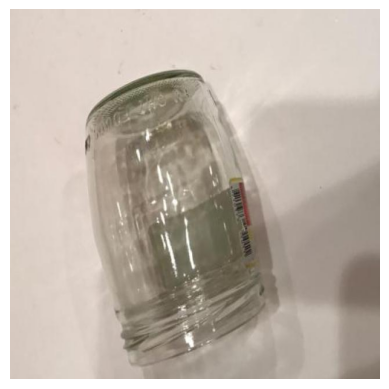

In [248]:
import pandas as pd

def merge_predictions_with_ground_truth(predictions_df, ground_truth_df):
    """
    Merges prediction and ground truth DataFrames on the image_path column,
    ensuring that each row from predictions_df has a matching row from ground_truth_df.
    If there are multiple matching rows in ground_truth_df, it will match the first one.
    
    Parameters:
    - predictions_df: DataFrame containing model predictions.
    - ground_truth_df: DataFrame containing ground truth data.

    Returns:
    - Merged DataFrame containing all rows from predictions_df and the matching row(s) from ground_truth_df.
    """
    # Perform a left join to ensure all rows from predictions_df are kept
    merged_df = pd.merge(
        predictions_df, ground_truth_df, 
        on=["image_path"], 
        how="left", 
        suffixes=("_pred", "_gt")
    )
    
    # Optional: To retain only unique ground truth information per image, group by `image_path`
    # and take the first ground truth match for each prediction.
    # Note: Only if you wish to match a single ground truth row per prediction row.
    merged_df = merged_df.drop_duplicates(subset=["image_path", "bbox_pred"], keep="first")

    # Ensure final DataFrame rows match the number of rows in predictions_df
    assert len(merged_df) == len(predictions_df), "Row count mismatch after merging."
    
    return merged_df

# Example usage
# Assuming you have predictions_df and ground_truth_df
merged_df = merge_predictions_with_ground_truth(pred_df, df)
print(merged_df['mask_pred'].head(0))
# print(pred_df.head())

image_path = "/home/users/lweber/trash_detector/datasets/taconet/train/images/Glass352_jpg.rf.f0b02e53652ec056459cd4b3d6c81b13.jpg"

matching_rows = merged_df[merged_df['image_path'] == image_path]
print(matching_rows)
print(len(matching_rows))

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)

# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axis ticks and labels
plt.show()


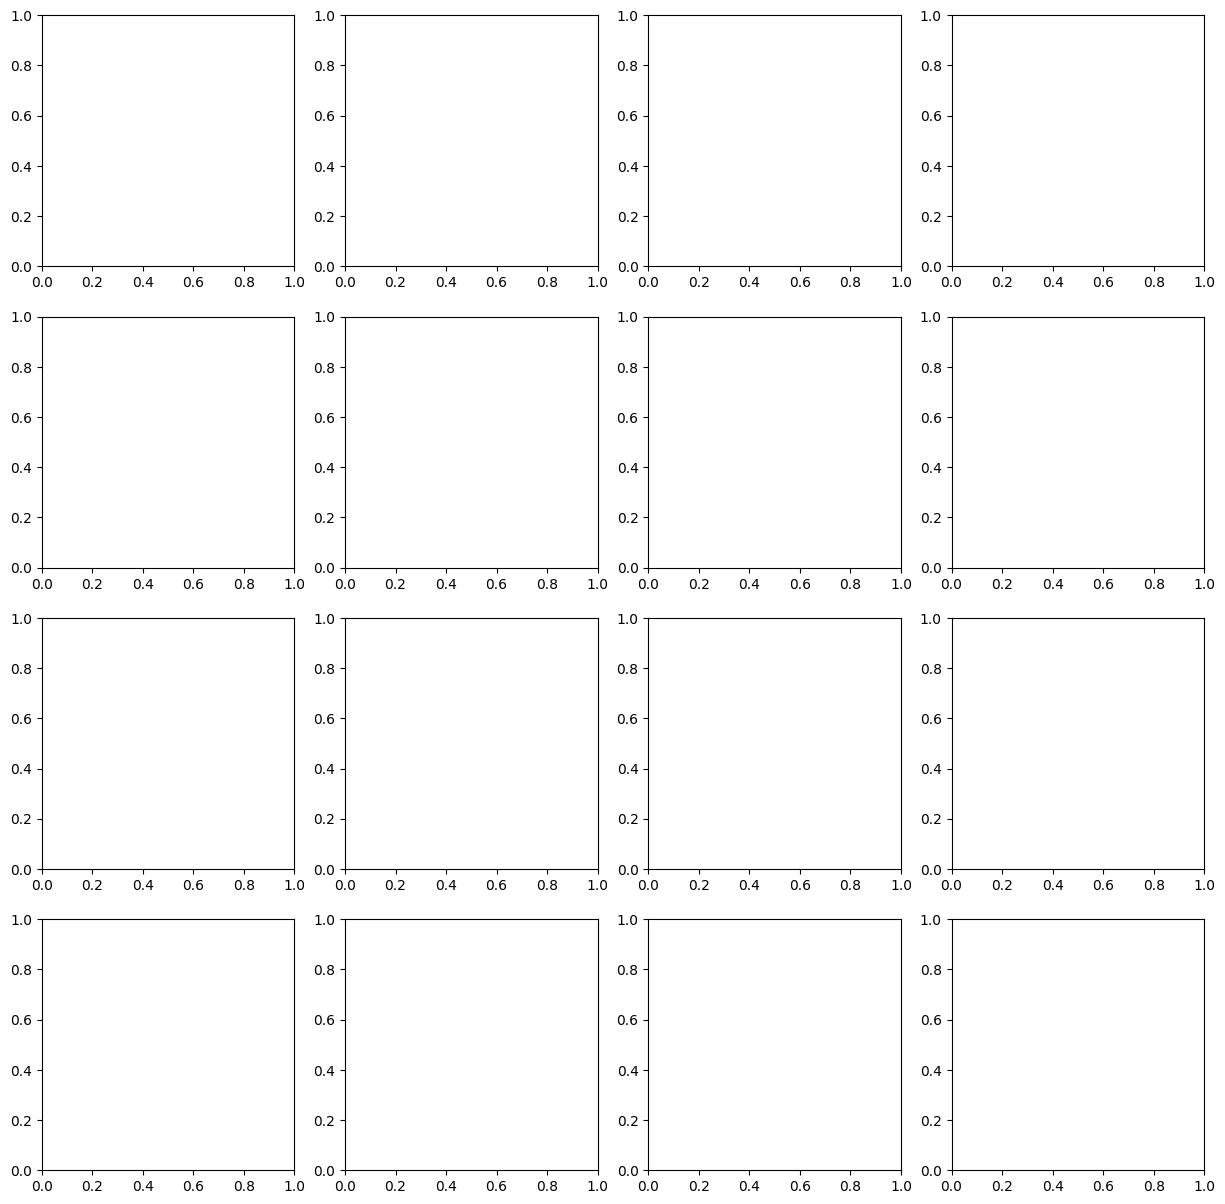

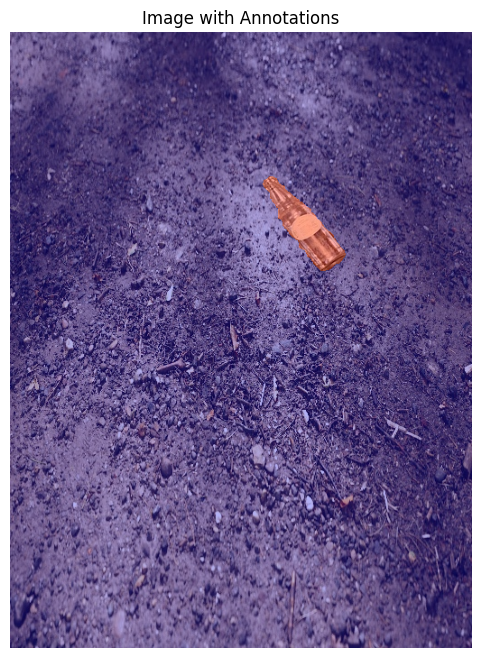

TypeError: Image data of dtype object cannot be converted to float

In [290]:
def display_images_with_label(dataframe, label, label_dir, grid_size=(4, 4)):
    """
    Displays images containing a specific label with their segmentation masks overlaid.

    Parameters:
    - dataframe: A DataFrame containing 'image_path', 'label', 'bbox', and 'mask' columns.
    - label: The label to filter images by.
    - label_dir: Directory where segmentation mask files are stored.
    - grid_size: Tuple representing the number of rows and columns in the plot grid.

    Returns:
    - None
    """
    # Filter the DataFrame for the specified label
    filtered_df = dataframe[dataframe['label'] == label]
    num_images = len(filtered_df)
    
    # Set up the plot grid
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, (idx, row) in enumerate(filtered_df.iterrows()):
        if i >= rows * cols:
            break  # Stop if we exceed grid size
        
        image_path = row['image_path']
        
        # Load the image with mask overlay using the custom function
        combined_image = visualize_annotation_with_image_by_path(image_path, label_dir)

        # Display the image with mask overlay
        axes[i].imshow(combined_image)
        axes[i].axis('off')
        axes[i].set_title(f"{label} - Image {i + 1}")
    
    # Hide any remaining empty subplots
    for j in range(i + 1, rows * cols):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

display_images_with_label(main_df, 6, "./datasets/taconet/train/labels")

In [138]:
def move_class_images(df, class_id, num_images, src_dir, dest_dir):
    """
    Moves a specified number of images of a given class to another directory.

    Parameters:
    - df: DataFrame containing image data, with 'class' and 'image_path' columns.
    - class_id: The class ID to filter (e.g., 6).
    - num_images: Number of images to move.
    - src_dir: Source directory where the images are currently stored.
    - dest_dir: Destination directory to move images to.
    
    Returns:
    - A DataFrame of the moved images.
    """
    # Ensure destination directory exists
    os.makedirs(dest_dir, exist_ok=True)
    
    # Filter for the rows with the specified class
    class_df = df[df['class'] == class_id].copy()
    
    # Select the specified number of images
    selected_df = class_df.head(num_images)
    
    # Move each selected image
    for _, row in selected_df.iterrows():
        src_path = os.path.join(src_dir, row['image_path'])
        dest_path = os.path.join(dest_dir, os.path.basename(row['image_path']))
        
        # Move the file
        if os.path.exists(src_path):
            shutil.move(src_path, dest_path)
        else:
            print(f"Warning: {src_path} does not exist.")
    
    return selected_df

# Example usage
# Assuming df has columns 'class' and 'image_path'
# moved_images_df = move_class_images(df, class_id=6, num_images=10, src_dir="path/to/source", dest_dir="path/to/destination")
print(moved_images_df)

NameError: name 'moved_images_df' is not defined

In [278]:
def move_images_by_class(data_df, target_class_id, move_dir):
    """
    Moves images containing a specified class ID to a different directory.

    Parameters:
    - data_df: DataFrame with columns 'image_path' and 'class_id'.
    - target_class_id: The class ID of images to move.
    - move_dir: Path to the directory where images with the specified class ID will be moved.

    Returns:
    - moved_files: List of moved image paths.
    """
    # Ensure the move directory exists
    os.makedirs(move_dir, exist_ok=True)
    
    moved_files = []

    # Filter the DataFrame for rows that contain the target class ID
    target_images = data_df[data_df['label'] == target_class_id]['image_path'].unique()

    # Loop through unique image paths that contain the target class ID
    for image_path in target_images:
        # Get the directory of the image directly from the DataFrame
        src_path = image_path
        dest_path = os.path.join(move_dir, os.path.basename(image_path))

        # Check if the image file exists at the source path
        if os.path.exists(src_path):
            # Move the file
            shutil.move(src_path, dest_path)
            moved_files.append(src_path)
            print(f"Moved {os.path.basename(image_path)} to {move_dir}")
        else:
            print(f"File not found: {src_path}")

    return moved_files

move_images_by_class(val_main_df, 7, "./datasets/taconet/tmp")
move_images_by_class(val_main_df, 8, "./datasets/taconet/tmp")

Moved taco-batch_3-img_4916.jpg to ./datasets/taconet/tmp
Moved taco-batch_2-000022.jpg to ./datasets/taconet/tmp
Moved taco-batch_5-000107.jpg to ./datasets/taconet/tmp
Moved taco-batch_7-000072.jpg to ./datasets/taconet/tmp
Moved taco-batch_12-000041.jpg to ./datasets/taconet/tmp
Moved aug_b884f18de3db4512a35366b7fcb75c24.jpg to ./datasets/taconet/tmp
Moved taco-batch_3-img_4921.jpg to ./datasets/taconet/tmp
Moved taco-batch_9-000058.jpg to ./datasets/taconet/tmp
Moved aug_973cc33b9dcb4a4f9c22d9e17f2d8c5f.jpg to ./datasets/taconet/tmp
Moved taco-batch_8-000051.jpg to ./datasets/taconet/tmp
Moved taco-batch_8-000052.jpg to ./datasets/taconet/tmp
Moved taco-batch_9-000049.jpg to ./datasets/taconet/tmp
Moved taco-batch_5-000020.jpg to ./datasets/taconet/tmp
Moved taco-batch_3-img_4928.jpg to ./datasets/taconet/tmp
Moved taco-batch_8-000026.jpg to ./datasets/taconet/tmp
Moved aug_23dfecb615d14b98895176f2007a73cf.jpg to ./datasets/taconet/tmp
Moved taco-batch_11-000073.jpg to ./datasets/t

['/home/users/lweber/trash_detector/datasets/taconet/val/images/taco-batch_5-000107.jpg',
 '/home/users/lweber/trash_detector/datasets/taconet/val/images/taco-batch_7-000072.jpg',
 '/home/users/lweber/trash_detector/datasets/taconet/val/images/taco-batch_12-000041.jpg',
 '/home/users/lweber/trash_detector/datasets/taconet/val/images/aug_b884f18de3db4512a35366b7fcb75c24.jpg',
 '/home/users/lweber/trash_detector/datasets/taconet/val/images/taco-batch_3-img_4921.jpg',
 '/home/users/lweber/trash_detector/datasets/taconet/val/images/taco-batch_9-000058.jpg',
 '/home/users/lweber/trash_detector/datasets/taconet/val/images/aug_973cc33b9dcb4a4f9c22d9e17f2d8c5f.jpg',
 '/home/users/lweber/trash_detector/datasets/taconet/val/images/taco-batch_8-000051.jpg',
 '/home/users/lweber/trash_detector/datasets/taconet/val/images/taco-batch_8-000052.jpg',
 '/home/users/lweber/trash_detector/datasets/taconet/val/images/taco-batch_9-000049.jpg',
 '/home/users/lweber/trash_detector/datasets/taconet/val/images

label
4    3859
1    3761
6    2859
5    2343
2    1997
3      29
0       1
Name: count, dtype: int64


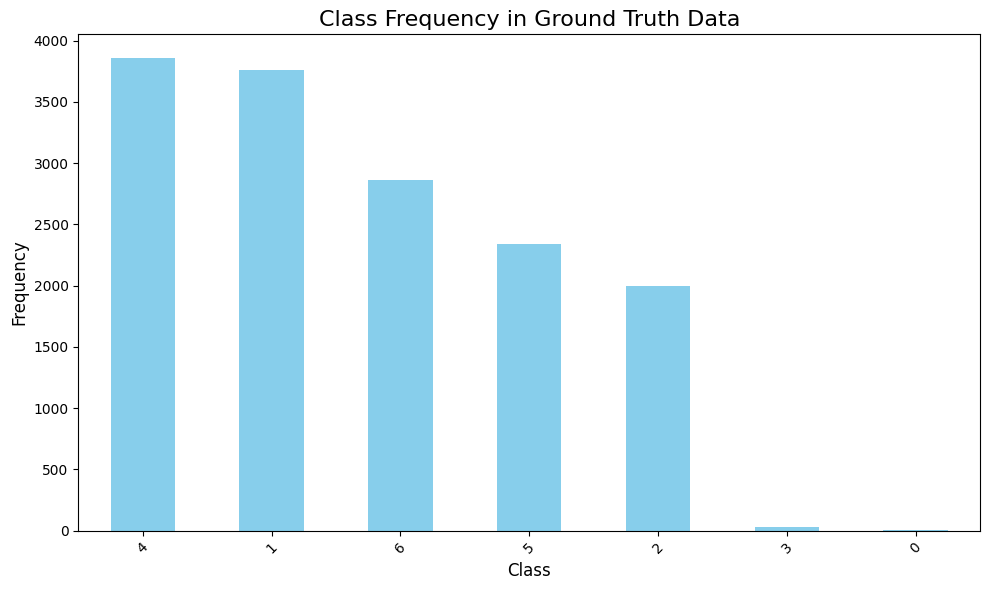

In [279]:

def plot_class_histogram(ground_truth_df):
    """
    Creates and displays a histogram showing the frequency of each class in the ground truth data.

    Parameters:
    - ground_truth_df: DataFrame containing ground truth data with a 'class' or 'label' column.
    
    Returns:
    - None
    """
    # Ensure the 'class' column exists in the DataFrame
    if 'label' not in ground_truth_df.columns:
        raise ValueError("The DataFrame does not contain a 'class' column.")
    
    # Count the occurrences of each class
    class_counts = ground_truth_df['label'].value_counts()
    print(class_counts)

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar', color='skyblue')
    
    # Adding labels and title
    plt.title('Class Frequency in Ground Truth Data', fontsize=16)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

plot_class_histogram(main_df)

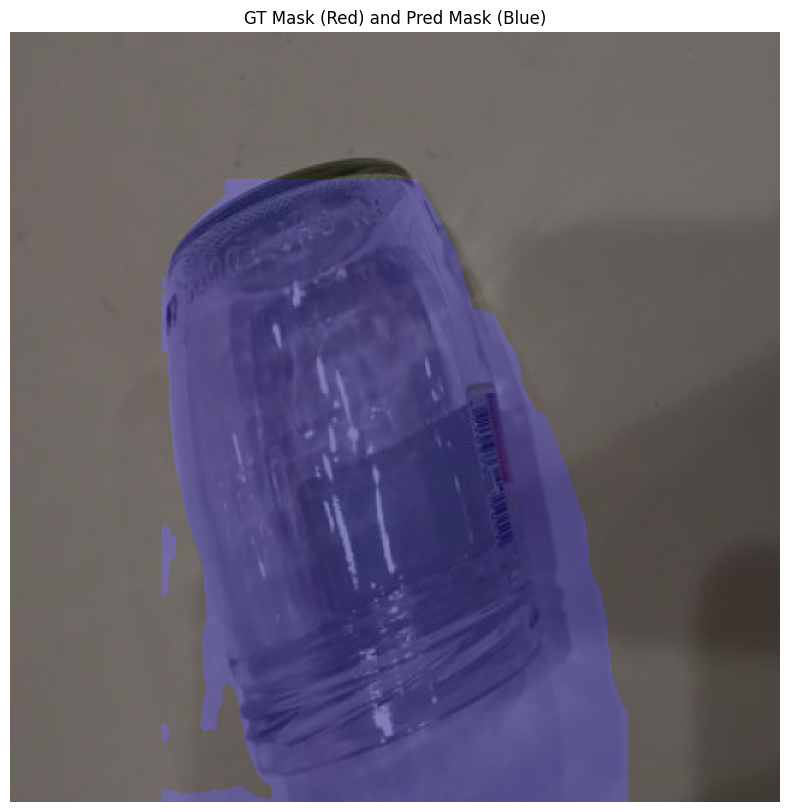

In [189]:
def polygon_to_mask(polygon, img_shape):
    """
    Converts a polygon (list of points) into a binary mask for the image.
    
    Parameters:
    - polygon: List of points representing a polygon (e.g., from mask_gt).
    - img_shape: Shape of the image (height, width).
    
    Returns:
    - binary_mask: Binary mask with the polygon filled in.
    """
    # Create an empty mask (all black)
    binary_mask = np.zeros(img_shape, dtype=np.uint8)
    
    # Convert the polygon points into a numpy array of integers
    polygon_points = np.array(polygon, dtype=np.int32)
    
    # Fill the polygon on the mask
    cv2.fillPoly(binary_mask, [polygon_points], color=255)  # Fill with white (255)
    
    return binary_mask

def plot_masks_on_image(image_path, merged_df):
    """
    Plots the ground truth and predicted masks for visual comparison, in a single image.
    
    Parameters:
    - image_path: Path to the input image.
    - merged_df: DataFrame containing masks for both ground truth and predicted objects.
    
    Returns:
    - None
    """
    # Load the original image
    image = cv2.imread(image_path)
    
    # Check if image is loaded successfully
    if image is None:
        print(f"Error loading image: {image_path}")
        return

    # Convert image to RGB for matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create empty mask images to overlay the GT and Pred masks
    gt_mask_overlay = np.zeros_like(image_rgb)
    pred_mask_overlay = np.zeros_like(image_rgb)

    merged_df = merged_df[merged_df['image_path'] == image_path]

    # Loop through the rows of the dataframe to process each object
    for _, row in merged_df.iterrows():
        # Get the GT and predicted masks (binary masks)
        gt_mask = row['mask_gt']  # Ground truth mask (list of polygon points)
        pred_mask = row['mask_pred']  # Predicted mask (binary mask)

        # Convert GT polygon mask to binary mask
        gt_mask_resized = polygon_to_mask(gt_mask, image.shape[:2])  # Convert GT polygon to binary mask
        gt_mask_resized = cv2.resize(gt_mask_resized, (image.shape[1], image.shape[0]))  # Resize GT mask to image size

        # Resize Pred mask to match image size
        pred_mask_resized = cv2.resize(pred_mask, (image.shape[1], image.shape[0]))  # Resize Pred mask to image size

        # Color the GT mask in red and the predicted mask in blue
        gt_mask_overlay[gt_mask_resized == 255] = [255, 0, 0]  # Red for GT mask
        pred_mask_overlay[pred_mask_resized == 255] = [0, 0, 255]  # Blue for predicted mask

    # Combine the GT and Pred masks into one image with transparency
    combined_mask = cv2.addWeighted(gt_mask_overlay, 0.5, pred_mask_overlay, 0.5, 0)

    # Plot the image with GT and Pred masks
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.imshow(combined_mask, alpha=0.5)  # Overlay the combined masks with some transparency
    plt.axis('off')  # Hide axes
    plt.title('GT Mask (Red) and Pred Mask (Blue)')
    plt.show()

image_path = "/home/users/lweber/trash_detector/datasets/taconet/train/images/Glass352_jpg.rf.f0b02e53652ec056459cd4b3d6c81b13.jpg"

plot_masks_on_image(image_path, merged_df)

In [43]:
def remove_images_and_labels(filtered_df):
    """
    Removes images and labels based on the 'image_path' and 'label_path' columns from the filtered DataFrame.
    
    Parameters:
    - filtered_df: DataFrame containing the columns 'image_path' and 'label_path'.
    
    Returns:
    - None
    """
    for _, row in filtered_df.iterrows():
        image_path = row['image_path']
        label_path = row['label_path']
        
        # Remove the image file if it exists
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Removed image: {image_path}")
        
        # Remove the label file if it exists
        if os.path.exists(label_path):
            os.remove(label_path)
            print(f"Removed label: {label_path}")


filtered_df = df[(df['label'] == 6) & (df['image_path'].str.contains("aug_"))]
remove_images_and_labels(filtered_df)
print(filtered_df)

Removed image: /home/users/lweber/trash_detector/datasets/taconet/train/images/aug_bc12c918f8f2456a83484b38d713c9c1.jpg
Removed label: /home/users/lweber/trash_detector/datasets/taconet/train/labels/aug_bc12c918f8f2456a83484b38d713c9c1.txt
Removed image: /home/users/lweber/trash_detector/datasets/taconet/train/images/aug_05840e7a86594532af20625e03f5444b.jpg
Removed label: /home/users/lweber/trash_detector/datasets/taconet/train/labels/aug_05840e7a86594532af20625e03f5444b.txt
Removed image: /home/users/lweber/trash_detector/datasets/taconet/train/images/aug_44b074304fcc4566855a08d02d3c060d.jpg
Removed label: /home/users/lweber/trash_detector/datasets/taconet/train/labels/aug_44b074304fcc4566855a08d02d3c060d.txt
Removed image: /home/users/lweber/trash_detector/datasets/taconet/train/images/aug_f133e023f1574a08bb72f74f9e12e244.jpg
Removed label: /home/users/lweber/trash_detector/datasets/taconet/train/labels/aug_f133e023f1574a08bb72f74f9e12e244.txt
Removed image: /home/users/lweber/trash_

In [48]:
filtered_df = df[(df['label'] == 6)]
print(filtered_df)

                                            image_path  \
0    /home/users/lweber/trash_detector/datasets/tac...   
1    /home/users/lweber/trash_detector/datasets/tac...   
2    /home/users/lweber/trash_detector/datasets/tac...   
3    /home/users/lweber/trash_detector/datasets/tac...   
4    /home/users/lweber/trash_detector/datasets/tac...   
..                                                 ...   
425  /home/users/lweber/trash_detector/datasets/tac...   
426  /home/users/lweber/trash_detector/datasets/tac...   
427  /home/users/lweber/trash_detector/datasets/tac...   
428  /home/users/lweber/trash_detector/datasets/tac...   
429  /home/users/lweber/trash_detector/datasets/tac...   

                                            label_path  label  \
0    /home/users/lweber/trash_detector/datasets/tac...      6   
1    /home/users/lweber/trash_detector/datasets/tac...      6   
2    /home/users/lweber/trash_detector/datasets/tac...      6   
3    /home/users/lweber/trash_detector/data

In [128]:
merged_df.isna().sum()

image_path    0
label_pred    0
bbox          0
mask_pred     0
label_gt      0
mask_gt       0
dtype: int64

In [310]:
main_df[main_df['mask'] == None]

Empty DataFrame
Columns: [image_path, label_path, label, mask, bbox]
Index: []

Empty label files found, displaying associated images:


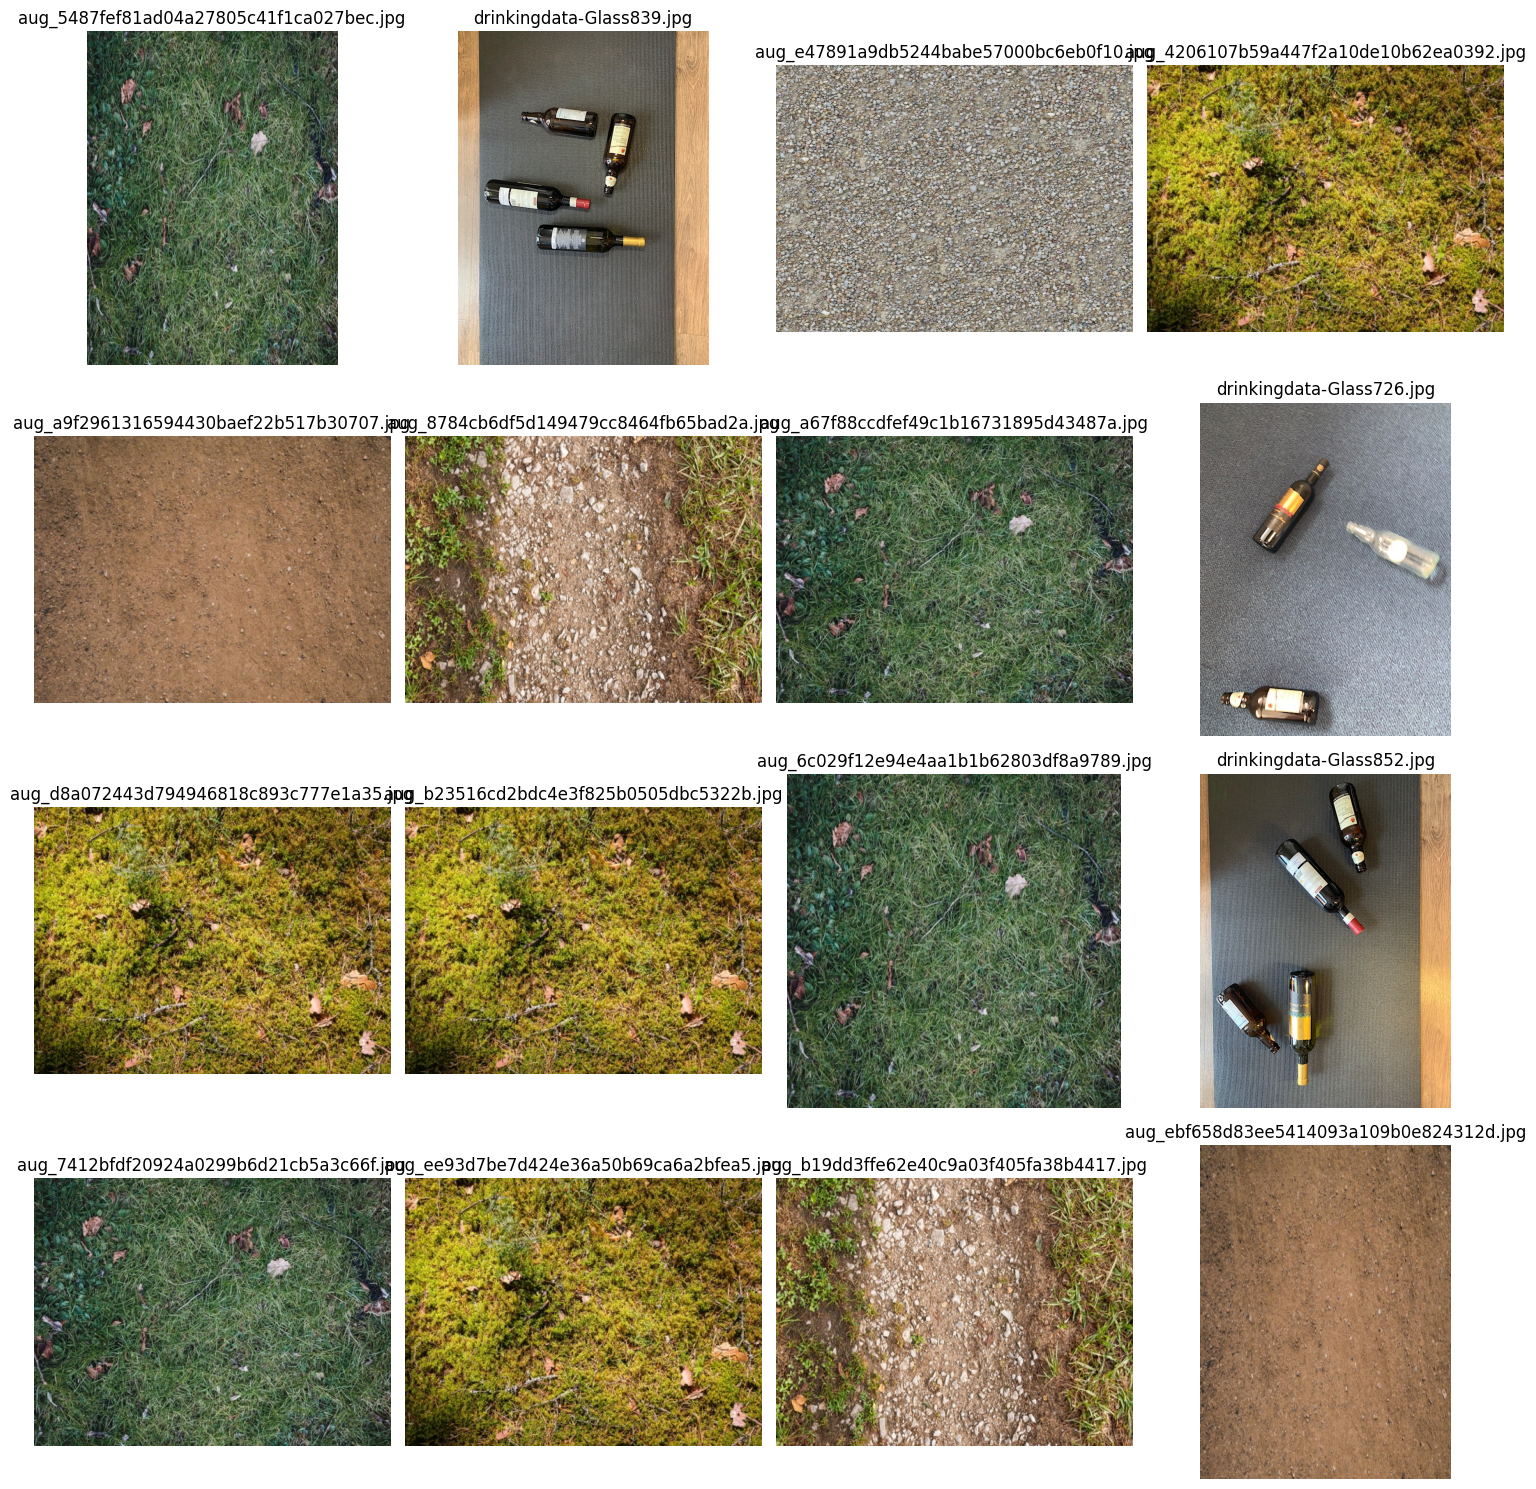

In [319]:
def find_and_move_empty_label_files(labels_dir, images_dir, target_dir):
    """
    Checks for empty label files in the specified directory, finds corresponding images,
    and moves both the empty label files and their associated images to a target directory.

    Parameters:
    - labels_dir: Directory containing label files.
    - images_dir: Directory containing the associated images.
    - target_dir: Directory to move the empty label files and images to.

    Returns:
    - List of paths to the moved empty label files and their associated images.
    """
    empty_files = []
    image_paths = []

    # Create the target directory if it does not exist
    os.makedirs(target_dir, exist_ok=True)

    # Traverse the directory for label files
    for root, _, files in os.walk(labels_dir):
        for label_file in files:
            if label_file.endswith('.txt'):
                label_path = os.path.join(root, label_file)
                
                # Check if the file is empty
                if os.path.getsize(label_path) == 0:
                    empty_files.append(label_path)
                    
                    # Find the corresponding image path
                    image_filename = os.path.splitext(label_file)[0] + ".jpg"  # Adjust if not .jpg
                    image_path = os.path.join(images_dir, image_filename)
                    
                    # Move the label file
                    target_label_path = os.path.join(target_dir, os.path.basename(label_path))
                    shutil.move(label_path, target_label_path)

                    if os.path.exists(image_path):
                        # Move the associated image file
                        target_image_path = os.path.join(target_dir, os.path.basename(image_path))
                        shutil.move(image_path, target_image_path)
                        image_paths.append(target_image_path)

    return empty_files, image_paths

def display_images_grid(image_paths, grid_size=(4, 4)):
    """
    Displays a grid of images.

    Parameters:
    - image_paths: List of paths to images to be displayed.
    - grid_size: Tuple indicating the grid dimensions (rows, columns).
    """
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, img_path in enumerate(image_paths[:rows * cols]):
        image = cv2.imread(img_path)
        if image is None:
            print(f"Error loading image: {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(os.path.basename(img_path))

    # Hide any remaining empty subplots:w
    for j in range(i + 1, rows * cols):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

labels_directory = "./datasets/taconet/train/labels"
images_directory = "./datasets/taconet/train/images"
empty_files, empty_image_paths = find_and_move_empty_label_files(labels_directory, images_directory, "./dataset/taconet/remove")

if empty_image_paths:
    print("Empty label files found, displaying associated images:")
    display_images_grid(empty_image_paths, grid_size=(4, 4))
else:
    print("No empty label files found.")

In [ ]:
def find_empty_label_files(labels_dir):
    """
    Checks for empty label files in the specified directory.

    Parameters:
    - labels_dir: Directory containing label files.

    Returns:
    - List of paths to empty label files.
    """
    empty_files = []

    # Traverse the directory for label files
    for root, _, files in os.walk(labels_dir):
        for label_file in files:
            if label_file.endswith('.txt'):
                label_path = os.path.join(root, label_file)
                
                # Check if the file is empty
                if os.path.getsize(label_path) == 0:
                    empty_files.append(label_path)

    return empty_files

labels_directory = "./datasets/taconet/train/labels"
images_directory = "./datasets/taconet/train/images"
find_empty_label_files(labels_directory, images_directory)


TypeError: find_empty_label_files() takes 1 positional argument but 2 were given